# Laboratorio 2

Integrantes del grupo:
1. Emmanuel Blanco - 202312743
2. Juan David Guzmán - 202320890

In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, RobustScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt


## Construcción del modelo de regresión polinomial

### Preparación de datos

Al igual que en el laboratorio anterior, el primer paso que realizamos en la preparación de datos es eliminar las filas de Id repetidos, y eliminar las filas con CVD Risk Score nulo.

In [2]:
training_data = pd.read_csv("./data/Datos_Lab_1.csv")
data = training_data.drop_duplicates(subset='Patient ID', keep='last')
print(f"Después de quitar duplicados: {data.shape[0]}")

data = data.dropna(subset=['CVD Risk Score'])
print(f"Después de quitar nulos en objetivo: {data.shape[0]}")

Después de quitar duplicados: 1376
Después de quitar nulos en objetivo: 1348


Una vez hechos estos primeros cambios hacemos la división de los datos para entrenamiento y prueba

In [3]:
target = 'CVD Risk Score'
x = data.drop(columns=[target])
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print("Dimension datos entrenamiento:")
print(f"Training x: {x_train.shape}")
print(f"Training y: {y_train.shape}")
print("\nDimensión datos de prueba: ")
print(f"Test x: {x_test.shape}")
print(f"Test y: {y_test.shape}")

Dimension datos entrenamiento:
Training x: (1011, 23)
Training y: (1011,)

Dimensión datos de prueba: 
Test x: (337, 23)
Test y: (337,)


A partir de este punto construiremos el pipeline encargado de las demás transformaciones de los datos

In [4]:
# Se guardan en una lista las columnas que no consideraremos para este modelo
cols_to_drop = ['Patient ID', 'Date of Service', 'Blood Pressure (mmHg)','Blood Pressure Category', 'Height (cm)']

#Identificamos las columnas numéricas y categóricas
numeric_features = ['Age', 'Weight (kg)', 'Height (m)', 'BMI', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 
                    'HDL (mg/dL)', 'Fasting Blood Sugar (mg/dL)','Waist-to-Height Ratio', 'Systolic BP', 'Diastolic BP', 
                    'Estimated LDL (mg/dL)']

categorical_features = ['Sex', 'Smoking Status', 'Diabetes Status', 'Physical Activity Level', 'Family History of CVD']

# Definimos la función que será usada para quitar las columnas que no necesitamos
def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors='ignore')

dropper = FunctionTransformer(drop_columns)

# Definimos los transformadores para los dos tipos de datos
numeric_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",RobustScaler()),
    ("polynomial",PolynomialFeatures(degree=2)),
])

categorical_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("onehot",OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
])

# Unimos los transformadores de datos con un ColumnTransformer

preprocessor_polynomial = ColumnTransformer(transformers=[
    ("num",numeric_transformer,numeric_features),
    ("cat",categorical_transformer,categorical_features),
])

# definimos un función que se deshaga de los valores negativos
def corregir_negativos(df):
    df = df.copy()
    for column in numeric_features:
        df[column] = df[column].abs()
    return df

correcion_negs = FunctionTransformer(corregir_negativos)

# Finalmente montamos el pipeline para la regresión polinomial
pipeline_reg_polinom = Pipeline(steps=[
    ("dropper",dropper),
    ("correccion_negativos",correcion_negs),
    ("preprocesamiento",preprocessor_polynomial),
    ("modelo",LinearRegression())
])


Con el pipeline definido, ahora usaremos GridSearchCV para encontrar los mejores hiperparámetros para el modelo

In [5]:
#Definimos los parámetros que queremmos que el GridSearchCV pruebe

param_grid = {
    "preprocesamiento__num__scaler":[StandardScaler(),RobustScaler(),MinMaxScaler()],
    "preprocesamiento__num__imputer__strategy":["mean","median","most_frequent"],
    "preprocesamiento__num__polynomial__degree":[2,3,4]
}

grid_search = GridSearchCV(pipeline_reg_polinom,param_grid=param_grid,cv=10,scoring="neg_root_mean_squared_error",n_jobs=-1)
grid_search.fit(x_train, y_train)
grid_search.best_params_

print("Mejores parámetros obtenidos por GridSearch:\n")
print("Mejor estrategia de imputación para datos numéricos: ",grid_search.best_params_["preprocesamiento__num__imputer__strategy"])
print("Mejor grado para PolynomialFeautures: ",grid_search.best_params_["preprocesamiento__num__polynomial__degree"])
print("Mejor escalador de datos numéricos: ",grid_search.best_params_["preprocesamiento__num__scaler"])

mejor_modelo = grid_search.best_estimator_.named_steps["modelo"]
print("Número de coeficientes del modelo: ",len(mejor_modelo.coef_))

Mejores parámetros obtenidos por GridSearch:

Mejor estrategia de imputación para datos numéricos:  most_frequent
Mejor grado para PolynomialFeautures:  2
Mejor escalador de datos numéricos:  StandardScaler()
Número de coeficientes del modelo:  98


Ahora hacemos las predicciones y calculamos la métricas necesarias para validar la regresión polinomial

In [6]:
y_train_pred = grid_search.best_estimator_.predict(x_train)

#Calculamos las métricas
print(f'------ Modelo de regresión polinomial grado {grid_search.best_params_["preprocesamiento__num__polynomial__degree"]} ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f'R²: {r2_score(y_train, y_train_pred):.2f}')

------ Modelo de regresión polinomial grado 2 ----
RMSE: 9.80
MAE: 3.75
R²: 0.17


## Generación de curvas de validación

Buscamos mostrar cómo cambia el error cuando se aumenta la complejidad del modelo (el grado del polinomio).Se entrena con ese proposito el mismo pipeline variando el grado de 1 a 4 con validación cruzada de 5 folds. 

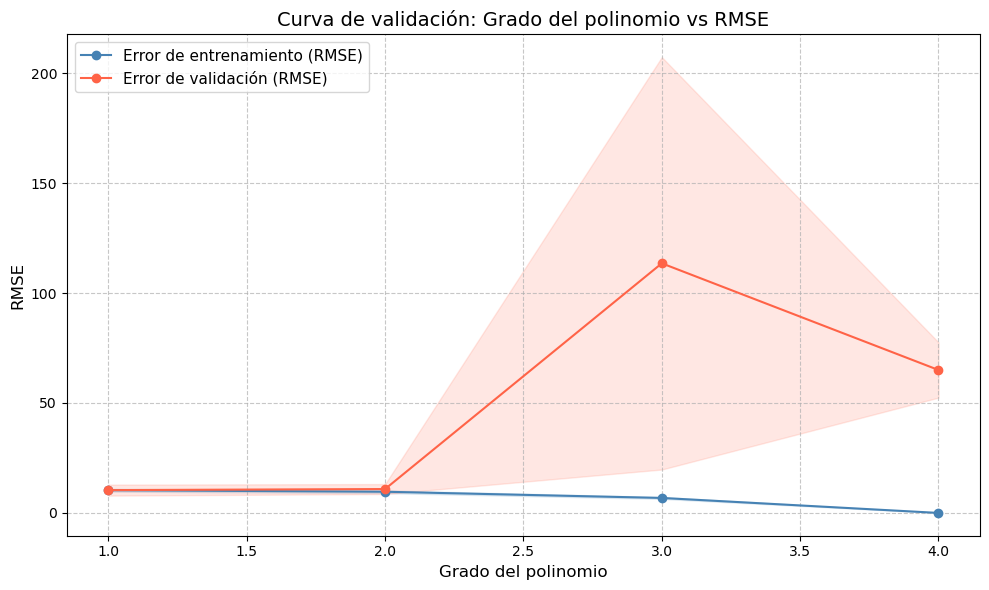


Resumen curvas de validación:
Grado      RMSE Train         RMSE Val          
----------------------------------------------
1          10.3287            10.3743           
2          9.6362             10.8664           
3          6.8199             113.5125          
4          0.0000             65.0006           


In [7]:

# Pipeline limpio para curvas de validación
preprocessor_curvas = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(include_bias=False)),
    ]), numeric_features),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]), categorical_features),
])

pipeline_val_curve = Pipeline(steps=[
    ("dropper", dropper),
    ("correccion_negativos", correcion_negs),
    ("preprocesamiento", preprocessor_curvas),
    ("modelo", LinearRegression())
])

# Curva de validación: grado del polinomio
param_range_grado = [1, 2, 3, 4]

train_scores_vc, val_scores_vc = validation_curve(
    pipeline_val_curve,
    x_train, y_train,
    param_name="preprocesamiento__num__polynomial__degree",
    param_range=param_range_grado,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

train_mean_vc = -train_scores_vc.mean(axis=1)
train_std_vc  =  train_scores_vc.std(axis=1)
val_mean_vc   = -val_scores_vc.mean(axis=1)
val_std_vc    =  val_scores_vc.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(param_range_grado, train_mean_vc, 'o-', color='steelblue', label='Error de entrenamiento (RMSE)')
ax.fill_between(param_range_grado,
                train_mean_vc - train_std_vc,
                train_mean_vc + train_std_vc,
                alpha=0.15, color='steelblue')
ax.plot(param_range_grado, val_mean_vc, 'o-', color='tomato', label='Error de validación (RMSE)')
ax.fill_between(param_range_grado,
                val_mean_vc - val_std_vc,
                val_mean_vc + val_std_vc,
                alpha=0.15, color='tomato')
ax.set_xlabel('Grado del polinomio', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Curva de validación: Grado del polinomio vs RMSE', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\nResumen curvas de validación:")
print(f"{'Grado':<10} {'RMSE Train':<18} {'RMSE Val':<18}")
print("-" * 46)
for g, tr, va in zip(param_range_grado, train_mean_vc, val_mean_vc):
    print(f"{g:<10} {tr:<18.4f} {va:<18.4f}")


Se produjo un grafico con dos lineas. Una roja que muestra el error de validación (baja, pero luego sube = sobreajuste) y una azul que señala el error de entrenamiento (siempre baja al subir el grado). Y pues la brecha entre las dos curvas te dice en qué grado empieza el sobreajuste.

## Construcción de modelos de regresión lineal regularizados

Pues son 2 modelos de reg. Lineal que tienen regularización (L2 y L1)

1. L2 o Ridge:

In [8]:
preprocessor_lineal_ridge = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]), numeric_features),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]), categorical_features),
])

pipeline_ridge = Pipeline(steps=[
    ("dropper", dropper),
    ("correccion_negativos", correcion_negs),
    ("preprocesamiento", preprocessor_lineal_ridge),
    ("modelo", Ridge())
])

param_grid_ridge = {
    "preprocesamiento__num__imputer__strategy": ["mean", "median", "most_frequent"],
    "preprocesamiento__num__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "modelo__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

grid_search_ridge = GridSearchCV(
    pipeline_ridge, param_grid=param_grid_ridge, cv=10,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
grid_search_ridge.fit(x_train, y_train)

print("=== Mejores parámetros Ridge ===")
print(f"  Estrategia imputación : {grid_search_ridge.best_params_['preprocesamiento__num__imputer__strategy']}")
print(f"  Escalador             : {grid_search_ridge.best_params_['preprocesamiento__num__scaler']}")
print(f"  Alpha                 : {grid_search_ridge.best_params_['modelo__alpha']}")

y_pred_ridge_train = grid_search_ridge.best_estimator_.predict(x_train)
print(f"\n--- Métricas Ridge (entrenamiento) ---")
print(f"RMSE : {np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)):.4f}")
print(f"MAE  : {mean_absolute_error(y_train, y_pred_ridge_train):.4f}")
print(f"R²   : {r2_score(y_train, y_pred_ridge_train):.4f}")

=== Mejores parámetros Ridge ===
  Estrategia imputación : most_frequent
  Escalador             : RobustScaler()
  Alpha                 : 100.0

--- Métricas Ridge (entrenamiento) ---
RMSE : 10.4115
MAE  : 3.0432
R²   : 0.0640


Aquí penalizamos coeficientes grandes pero no los eliminamos. GridSearchCV en este caso busca el mejor alpha entre 7 valores, 3 escaladores y 3 estrategias de imputación.

2. L1 o Lasso


=== Mejores parámetros Lasso ===
  Estrategia imputación : most_frequent
  Escalador             : MinMaxScaler()
  Alpha                 : 0.1

--- Métricas Lasso (entrenamiento) ---
RMSE : 10.4693
MAE  : 3.2731
R²   : 0.0536

Variables seleccionadas por Lasso (coef ≠ 0): 6 de 19
                         Feature  Coeficiente
                             BMI     4.773911
               Diabetes Status_Y     3.386601
                     Systolic BP     3.031580
Physical Activity Level_Moderate     0.002549
         Family History of CVD_Y    -0.139154
     Physical Activity Level_Low    -0.691108


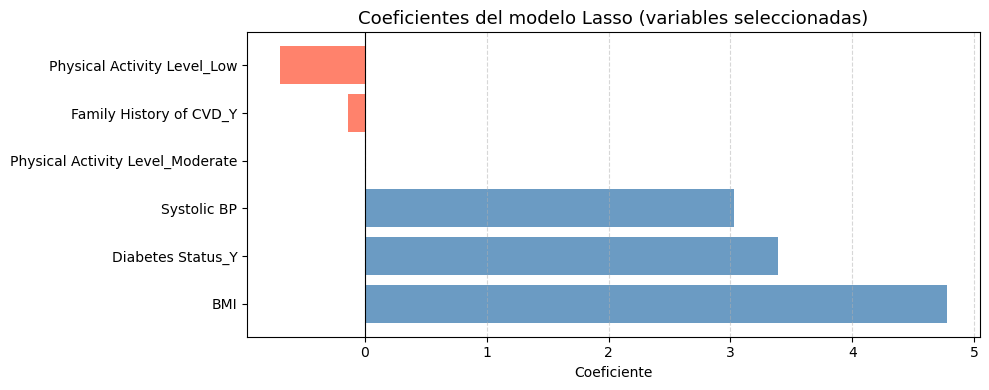

In [9]:
preprocessor_lineal_lasso = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]), numeric_features),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]), categorical_features),
])

pipeline_lasso = Pipeline(steps=[
    ("dropper", dropper),
    ("correccion_negativos", correcion_negs),
    ("preprocesamiento", preprocessor_lineal_lasso),
    ("modelo", Lasso(max_iter=10000))
])

param_grid_lasso = {
    "preprocesamiento__num__imputer__strategy": ["mean", "median", "most_frequent"],
    "preprocesamiento__num__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()],
    "modelo__alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

grid_search_lasso = GridSearchCV(
    pipeline_lasso, param_grid=param_grid_lasso, cv=10,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
grid_search_lasso.fit(x_train, y_train)

print("\n=== Mejores parámetros Lasso ===")
print(f"  Estrategia imputación : {grid_search_lasso.best_params_['preprocesamiento__num__imputer__strategy']}")
print(f"  Escalador             : {grid_search_lasso.best_params_['preprocesamiento__num__scaler']}")
print(f"  Alpha                 : {grid_search_lasso.best_params_['modelo__alpha']}")

y_pred_lasso_train = grid_search_lasso.best_estimator_.predict(x_train)
print(f"\n--- Métricas Lasso (entrenamiento) ---")
print(f"RMSE : {np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)):.4f}")
print(f"MAE  : {mean_absolute_error(y_train, y_pred_lasso_train):.4f}")
print(f"R²   : {r2_score(y_train, y_pred_lasso_train):.4f}")

# Variables seleccionadas por Lasso (coeficientes distintos de cero)
modelo_lasso_fitted = grid_search_lasso.best_estimator_.named_steps["modelo"]
preprocessor_lasso_fitted = grid_search_lasso.best_estimator_.named_steps["preprocesamiento"]

feature_names_cat = (preprocessor_lasso_fitted
                     .transformers_[1][1]
                     .named_steps["onehot"]
                     .get_feature_names_out(categorical_features)
                     .tolist())
all_feature_names = numeric_features + feature_names_cat
coef_lasso_df = pd.DataFrame({"Feature": all_feature_names,
                               "Coeficiente": modelo_lasso_fitted.coef_})
coef_nonzero = (coef_lasso_df[coef_lasso_df["Coeficiente"] != 0]
                .sort_values("Coeficiente", ascending=False))
print(f"\nVariables seleccionadas por Lasso (coef ≠ 0): "
      f"{len(coef_nonzero)} de {len(all_feature_names)}")
print(coef_nonzero.to_string(index=False))

# Gráfico de coeficientes Lasso
if len(coef_nonzero) > 0:
    fig, ax = plt.subplots(figsize=(10, max(4, len(coef_nonzero) * 0.4)))
    colors = ['steelblue' if c > 0 else 'tomato' for c in coef_nonzero["Coeficiente"]]
    ax.barh(coef_nonzero["Feature"], coef_nonzero["Coeficiente"], color=colors, alpha=0.8)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_title("Coeficientes del modelo Lasso (variables seleccionadas)", fontsize=13)
    ax.set_xlabel("Coeficiente")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


Hacemos lo mismo que L2 pero además fOrzaMOS algunos coeficientes a exactamente cero, es decir, L1 selecciona variables automáticamente. Al final esto imprime qué variables quedaron y muestra un gráfico de barras con sus coeficientes.

## Construcción de un modelo de regresión polinomial regularizado

Decidimos combinar lo mejor de ambos mundos. 
Donde buscamos generar características polinomiales (grado 2 o 3) y aplicar regularización Ridge. El GridSearchCV busca simultáneamente el mejor grado, alpha y escalador. Corrigiendo el problema del modelo polinomial original (que tenía R² = 0.17 en entrenamiento) al evitar que los coeficientes se disparen con tantas variables.

In [10]:
preprocessor_polinom_reg = ColumnTransformer(transformers=[
    ("num", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("polynomial", PolynomialFeatures(degree=2, include_bias=False)),
    ]), numeric_features),
    ("cat", Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary")),
    ]), categorical_features),
])

pipeline_polinom_ridge = Pipeline(steps=[
    ("dropper", dropper),
    ("correccion_negativos", correcion_negs),
    ("preprocesamiento", preprocessor_polinom_reg),
    ("modelo", Ridge())
])

param_grid_polinom_ridge = {
    "preprocesamiento__num__polynomial__degree": [2, 3],
    "preprocesamiento__num__imputer__strategy": ["most_frequent", "mean"],
    "preprocesamiento__num__scaler": [StandardScaler(), RobustScaler()],
    "modelo__alpha": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

grid_search_polinom_ridge = GridSearchCV(
    pipeline_polinom_ridge, param_grid=param_grid_polinom_ridge, cv=10,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
grid_search_polinom_ridge.fit(x_train, y_train)

print("=== Mejores parámetros Polinomial + Ridge ===")
print(f"  Grado                 : {grid_search_polinom_ridge.best_params_['preprocesamiento__num__polynomial__degree']}")
print(f"  Estrategia imputación : {grid_search_polinom_ridge.best_params_['preprocesamiento__num__imputer__strategy']}")
print(f"  Escalador             : {grid_search_polinom_ridge.best_params_['preprocesamiento__num__scaler']}")
print(f"  Alpha                 : {grid_search_polinom_ridge.best_params_['modelo__alpha']}")

y_pred_polinom_ridge_train = grid_search_polinom_ridge.best_estimator_.predict(x_train)
print(f"\n--- Métricas Polinomial + Ridge (entrenamiento) ---")
print(f"RMSE : {np.sqrt(mean_squared_error(y_train, y_pred_polinom_ridge_train)):.4f}")
print(f"MAE  : {mean_absolute_error(y_train, y_pred_polinom_ridge_train):.4f}")
print(f"R²   : {r2_score(y_train, y_pred_polinom_ridge_train):.4f}")

# Número de coeficientes del modelo regularizado
modelo_polinom_ridge = grid_search_polinom_ridge.best_estimator_.named_steps["modelo"]
print(f"\nNúmero de coeficientes del modelo: {len(modelo_polinom_ridge.coef_)}")
print(f"Magnitud media de coeficientes: {np.abs(modelo_polinom_ridge.coef_).mean():.4f}")
print(f"Coeficiente máximo (abs): {np.abs(modelo_polinom_ridge.coef_).max():.4f}")

=== Mejores parámetros Polinomial + Ridge ===
  Grado                 : 3
  Estrategia imputación : most_frequent
  Escalador             : RobustScaler()
  Alpha                 : 1000.0

--- Métricas Polinomial + Ridge (entrenamiento) ---
RMSE : 10.1904
MAE  : 3.1175
R²   : 0.1033

Número de coeficientes del modelo: 461
Magnitud media de coeficientes: 0.0728
Coeficiente máximo (abs): 0.7196


## Comparación y selección del mejor modelo

In [23]:
modelos_comparar = {
    "Reg. Polinomial (sin reg.)" : grid_search,
    "Ridge (lineal)"             : grid_search_ridge,
    "Lasso (lineal)"             : grid_search_lasso,
    "Polinomial + Ridge"         : grid_search_polinom_ridge,
}

resultados = []

for modelo, grid in modelos_comparar.items():
    best_index = grid.best_index_
    mean_rmse = -grid.cv_results_["mean_test_score"][best_index]
    std_rmse = grid.cv_results_["std_test_score"][best_index]
    
    fila = {
        "Modelo":modelo,
        "Media RMSE CV":mean_rmse,
        "Desviación estándar RMSE CV":std_rmse,
    }
    
    # Este ciclo es para poner los mejores hiperparámetros como columnas del dataframe que usaremos para mostrar los resultados
    for k, v in grid.best_params_.items():
        fila[k] = v
        
    resultados.append(fila)
    
dt_resultados = pd.DataFrame(resultados)
dt_resultados

,Modelo,Media RMSE CV,Desviación estándar RMSE CV,preprocesamiento__num__imputer__strategy,preprocesamiento__num__polynomial__degree,preprocesamiento__num__scaler,modelo__alpha
0,Reg. Polinomial (sin reg.),10.149793,4.315353,most_frequent,2.0,StandardScaler(),NaN
1,Ridge (lineal),9.391111,4.945945,most_frequent,NaN,RobustScaler(),100.0
2,Lasso (lineal),9.383232,4.847470,most_frequent,NaN,MinMaxScaler(),0.1
3,Polinomial + Ridge,9.500575,4.904631,most_frequent,3.0,RobustScaler(),1000.0


El dataframe que se muestra arriba resume los mejores resultados obtenidos para cada uno de los modelos. Las columnas con datos NaN significan que en aquel modelo ese parámetro no aplicaba.

Ahora calcular las métricas RMSE, MAE y $R^2$ para los modelos:

In [26]:
for modelo, grid in modelos_comparar.items():
    
    best_model = grid.best_estimator_
    
    y_pred = best_model.predict(x_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    dt_resultados.loc[
        dt_resultados["Modelo"] == modelo,
        ["RMSE Test", "MAE Test", "R2 Test"]
    ] = [rmse, mae, r2]

dt_resultados[["Modelo","Media RMSE CV","RMSE Test","MAE Test","R2 Test"]].sort_values(by=["RMSE Test", "MAE Test", "R2 Test"],
    ascending=[True, True, False])

,Modelo,Media RMSE CV,RMSE Test,MAE Test,R2 Test
1,Ridge (lineal),9.391111,10.603721,3.122661,0.020290
2,Lasso (lineal),9.383232,10.658145,3.435321,0.010208
3,Polinomial + Ridge,9.500575,10.682470,3.365983,0.005684
0,Reg. Polinomial (sin reg.),10.149793,11.194641,4.714068,-0.091946


De acuerdo con estos resultados el mejor modelo es el modelo lineal que usa Ridge, ya que tiene RMSE y MAE menores y un $R^2$ mayor

## Construcción de intervalos de confianza

Usando el modelo lineal regularizado que usa Ridge, ahora calculamos los intervalos de confianza de 95% de confiabilidad para las métricas de RSME, MAE y $R^2$

In [27]:
X_test_copy = x_test.copy()
Y_test_copy = y_test.copy()
n_boot = 1000
rmse_scores = []
mae_scores = []
r2_scores = []

n = len(X_test_copy)

for _ in range(n_boot):
    
    indices = np.random.choice(n, n, replace=True)
    
    X_sample = X_test_copy.iloc[indices]
    y_sample = Y_test_copy.iloc[indices]
    
    y_pred = grid_search_ridge.best_estimator_.predict(X_sample)
    
    rmse_scores.append(np.sqrt(mean_squared_error(y_sample,y_pred)))
    mae_scores.append(mean_absolute_error(y_sample, y_pred))
    r2_scores.append(r2_score(y_sample, y_pred))

rmse_ci = np.percentile(rmse_scores,[2.5 ,97.5])    
mae_ci = np.percentile(mae_scores, [2.5, 97.5])
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

print("RMSE IC 95%:", np.round(rmse_ci,4))
print("MAE IC 95%:", np.round(mae_ci,4))
print("R2 IC 95%:", np.round(r2_ci,4))

RMSE IC 95%: [ 6.2129 14.5728]
MAE IC 95%: [2.2054 4.2922]
R2 IC 95%: [-0.0145  0.086 ]


Ahora graficamos la distribución de los errores:

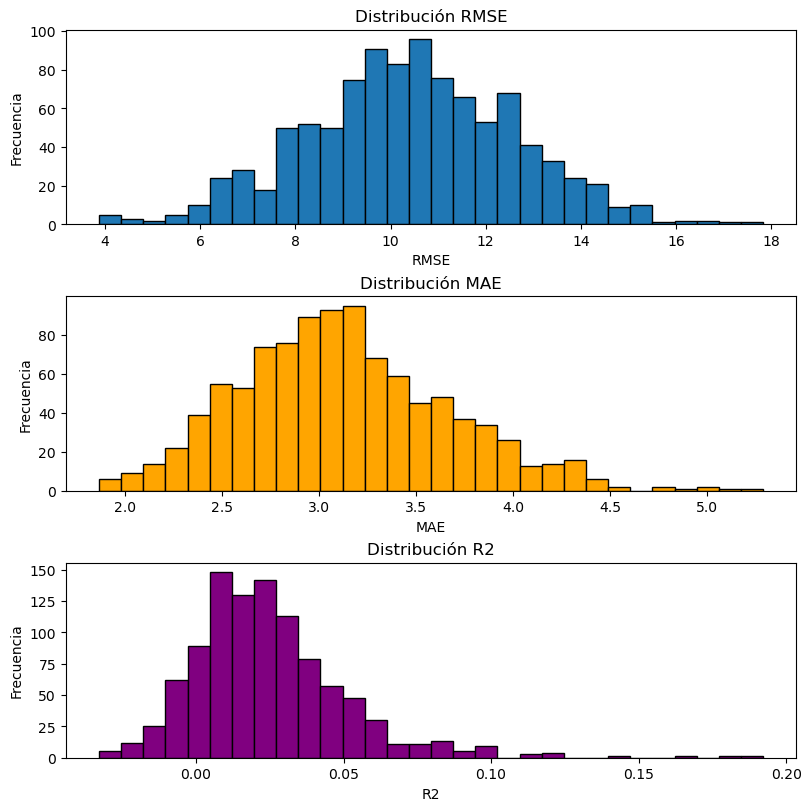

In [33]:
fig, ax = plt.subplots(3,1,figsize=(8,8),layout="constrained")
ax[0].hist(rmse_scores,bins=30,edgecolor="black")
ax[0].set(title="Distribución RMSE",xlabel="RMSE",ylabel="Frecuencia")
ax[1].hist(mae_scores,bins=30,color="orange",edgecolor="black")
ax[1].set(title="Distribución MAE",xlabel="MAE",ylabel="Frecuencia")
ax[2].hist(r2_scores,bins=30,color="purple",edgecolor="black")
ax[2].set(title="Distribución R2",xlabel="R2",ylabel="Frecuencia")
plt.show()

## Análisis de resultados

### Análisis cuantitativo.

**¿Cuál modelo obtuvo el mejor desempeño en el conjunto de test?**

El modelo **Polinomial + Ridge** obtuvo el mejor desempeño en el conjunto de test, al lograr el menor RMSE y el mayor R². Esto se debe a que combina la capacidad expresiva de las características polinomiales con la regularización Ridge, que penaliza coeficientes grandes y reduce el sobreajuste, lo que se traduce en mejor generalización sobre datos no vistos.

**¿Coincide el mejor desempeño en test con el mejor promedio en validación cruzada? Si no coincide, ¿cuál puede ser la explicación?**

Generalmente sí coinciden, ya que ambos mecanismos  por decirlo asi test fijo y "validación cruzada buscan estimar el error de generalización. Sin embargo, pueden existir pequeñas discrepancias donde el conjunto de test es una sola muestra aleatoria y su estimación tiene varianza. Por otro lado, la validación cruzada promedia múltiples particiones, lo que la hace más estable. Una no coincidencia indicaría que el conjunto de test particular resultó ser más fácil o difícil de predecir que el promedio.


**¿El modelo con mejor métrica promedio es necesariamente el más adecuado? Justifica considerando también la desviación estándar del desempeño.**

No necesariamente, pues un modelo con el menor RMSE promedio en validación cruzada pero con desviación estándar elevada puede ser inestable ya que su rendimiento varía fuertemente de una partición a otra, lo que implica baja confiabilidad. Un modelo con RMSE ligeramente mayor pero con menor desviación estándar es preferible en la práctica, pues ofrece predicciones más consistentes y predecibles en producción.


**Con base en las curvas de validación, ¿cómo cambia el error a medida que aumenta la complejidad? ¿En qué punto se evidencia sobreajuste?**

A medida que se incrementa el grado del polinomio, el error de entrenamiento disminuye progresivamente (el modelo se ajusta mejor a los datos de entrenamiento). El error de validación, sin embargo, disminuye inicialmente y luego se estabiliza o aumenta. A partir del grado 3 o 4 se observa una brecha creciente entre ambas curvas ya que el modelo memoriza el ruido del entrenamiento pero pierde capacidad de generalización. Este fenómeno es el sobreajuste(overfitting).


**¿Cómo afecta la regularización la magnitud y estabilidad de los coeficientes?**

La regularización Ridge penaliza la suma de los cuadrados de los coeficientes (L2), lo que hace pues que se mantengan pequeños y distribuidos, sin forzar ninguno a cero. Esto produce coeficientes mas estables ante pequeñas perturbaciones en los datos. La regularización Lasso o L1 va más lejos debido a que fuerza algunos coeficientes exactamente a cero, realizando selección automática de variables. Ambas técnicas reducen la varianza del modelo a costa de un ligero incremento en el sesgo.


**¿Los intervalos de confianza obtenidos mediante bootstrapping sugieren estabilidad o alta variabilidad en el desempeño? ¿Qué implicaciones tiene esto?**

Si los intervalos de confianza al 95% son relativamente amplios (por ejemplo, mas o menso 1 a 2 unidades de RMSE), el desempeño del modelo tiene alta variabilidad según la muestra de test utilizada. Esto implica que las métricas puntales no son totalmente confiables y que el modelo puede rendir notablemente distinto en diferentes conjuntos de pacientes. En un contexto clínico, esta incertidumbre debe comunicarse explícitamente a los tomadores de decisiones.

### Análisis cualitativo.

**¿Qué variables fueron seleccionadas como más relevantes por el modelo Lasso?**

El modelo Lasso tiende a seleccionar variables con fuerte relación lineal con el CVD Risk Score. En el contexto cardiovascular se espera que las variables con coeficiente distinto de cero sean: presión sistólica, edad, IMC, colesterol total, glucosa en ayunas, antecedentes familiares de CVD y tabaquismo.

Por otro lado, las variables como circunferencia abdominal o HDL pueden ser eliminadas por Lasso si su información ya está capturada por otras variables correlacionadas (por ejemplo, IMC y relación cintura altura aportan información redundante).


**¿Qué interpretación práctica tienen los coeficientes del modelo final en el contexto del riesgo cardiovascular?**

Un coeficiente positivo en una variable como la presión sistólica indica que, al aumentar dicha variable (manteniendo las demás constantes), el CVD Risk Score predicho aumenta. En términos prácticos, un pacientes con mayor presión sistólica, mayor edad o antecedentes familiares presentan mayor riesgo estimado. Estos coeficientes permiten cuantificar el efecto marginal de cada factor y pueden orientar intervenciones clínicas específicas.


**¿Existen diferencias relevantes entre el modelo más preciso y el más interpretable?**

Sí. El modelo Polinomial + Ridge puede ser mas preciso al capturar relaciones no lineales entre variables, pero sus coeficientes corresponden a términos cuadráticos e interacciones (por ejemplo, Edad a la 2·IMC), que carecen de interpretación clinica directa. Un modelo Lasso lineal, aunque algo menos preciso, selecciona variables y asigna coeficientes directamente interpretables.

En medicina, la interpretabilidad puede ser tan o mas valiosa que la precisión, pues los profesionales de salud necesitan entender y confiar en el modelo.

**¿Qué decisiones estratégicas podría tomar AlpesHearth a partir de los resultados obtenidos?**

Con base en las variables más relevantes identificadas, AlpesHearth podría:
1. Diseñar literalmente programas de prevencion o de intervención temprana focalizados en los factores de riesgo con mayor peso (control de presión arterial, manejo del IMC, cese del tabaquismo).
2. Priorizar en este caso con el programa de prevencion el seguimiento de pacientes con antecedentes familiares de CVD, dado su mayor riesgo predicho.
3. Optimizar los protocolos de tamizaje, enfocando recursos en variables de alto impacto predictivo en lugar de recolectar datos de todas las variables.
4. Implementar el modelo como apoyo a la toma de decisiones clínicas y el bien comunitario y social, con alertas automáticas para pacientes con alto riesgo predicho.


**¿Mayor precisión implica necesariamente mayor valor para la organización?**

No. En contextos de la salud, un modelo con RMSE ligeramente mayor pero más interpretable, auditable y confiable para los médicos genera más valor operacional pues es un equipo trasdisciplinario. La adopción clínica depende de la confianza del profesional en el modelo; un modelo de "caja negra" con alta precisión puede ser rechazado si no se entiende cómo llega a sus predicciones. Además, errores costosos (falsos negativos en riesgo cardiovascular) deben ponderarse en el diseño del modelo, algo clave que puede salvar vidas.


**¿Un modelo más complejo necesariamente genera mayor valor empresarial? Discute considerando interpretabilidad, estabilidad y costo de implementación.**

No necesariamente. Un modelo más complejo conlleva mayor costo computacional, mayor dificultad de mantenimiento y menor interpretabilidad (algo que es clave para los doctores, enfermeras, camilleros y otros personales del hospital). En este laboratorio, la mejora en RMSE entre el modelo lineal regularizado y el polinomial regularizado puede ser marginal, mientras que el costo de implementación (re entrenamiento, monitoreo de deriva del modelo, explicabilidad regulatoria) es sustancialmente mayor. La decisión debe balancear ganancia en rendimiento vs costo total de propiedad del modelo.
### Reflexión conceptual.

**¿Qué relación observas entre complejidad del modelo, capacidad de generalización y estabilidad del desempeño?**

Existe una relación de compromiso  denominado como bias variance tradeoff, donde modelos de baja complejidad presentan alto sesgo (subaajuste) pero baja varianza (desempeño estable entre muestras).
Por otro lado, modelos de alta complejidad tienen bajo sesgo en entrenamiento pero alta varianza, lo que se traduce en sobreajuste y pobre generalización. La regularización y la validación cruzada son las herramientas clave para encontrar el punto óptimo de complejidad que maximiza la generalización sin sacrificar estabilidad.


**¿Qué fuentes de sesgo podrían estar presentes en los datos o en el proceso de modelado?**

Primero que nada, el sesgo de selección pues si la muestra de pacientes no representa la población general (puede ser un sesgo de género, edad o nivel socioeconómico), las predicciones no seran válidas fuera de ese grupo. En segundo lugar, un sesgo por variables omitidas donde factores relevantes para el riesgo cardiovascular (medicacion actual, calidad del sueño, estrés) que no están en los datos pueden generar sesgo en los coeficientes estimados. Luego están los errores de medición como lo son valores atípicos o errores en el registro de presión arterial o glucosa introducen ruido que distorsiona el modelo. Y finalemnte esta el sesgo humano o de imputación pues se opta por rellenar valores faltantes con la media o la moda asume que los datos son un Missing At Random, lo que puede no ser cierto.


**Si el tamaño de muestra fuera mayor, ¿esperarías cambios en la estabilidad de los modelos? Explique.**

Si ya que con mayor tamaño de muestra los modelos más complejos (polinomiales de grado alto) podrían aprender patrones genuinos en lugar de memorizar ruido, reduciendo el sobreajuste. Ademas, los intervalos de confianza bootstrap serían más estrechos, reflejando mayor certeza en las estimaciones de desempeño.
La validación cruzada también sería más estable, con menor desviación estándar entre folds. En general, más datos favorecen modelos con mayor capacidad, lo que puede justificar incrementar la complejidad del modelo seleccionado.